<a href="https://colab.research.google.com/github/amiqdam/learning-journey/blob/main/copy_of_Inference_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Part 1: TensorFlow-Based Inference Engine Comparison

In this section, we'll build and train an image classification model using **TensorFlow/Keras** on the CIFAR-10 dataset, then evaluate it across multiple inference formats.

## 🧠 Objectives
- Train a simple CNN model in TensorFlow
- Export the model to:
  - ✅ **TFLite** (TensorFlow Lite)
  - ✅ **ONNX** (via `tf2onnx`)
- Evaluate and compare:
  - ✅ Accuracy on test set
  - ⚡ Inference latency
  - 📦 Model file size

## 🔄 Export Flow
TensorFlow (.h5 / SavedModel)
├──→ TensorFlow Lite (.tflite)
└──→ ONNX (.onnx) via tf2onnx


## 🚀 Inference Engines Compared

| Engine         | Description                                             |
|----------------|---------------------------------------------------------|
| TensorFlow     | Full-featured training & inference framework            |
| TFLite         | Lightweight runtime optimized for mobile/edge devices   |
| ONNX Runtime   | Cross-platform high-performance inference engine        |

## 📦 Tools
- TensorFlow 2.x
- TensorFlow Lite Converter
- tf2onnx
- ONNX Runtime (Python)

In [ ]:
!pip install -q tensorflow tensorflow-datasets
!pip install -q tf2onnx onnx onnxruntime
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import time
import os
import tf2onnx
import onnx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
opentelemetry

In [ ]:
# Load CIFAR-10 dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Preprocessing: Resize and normalize
IMG_SIZE = 224  # MobileNetV2 expects 224x224

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

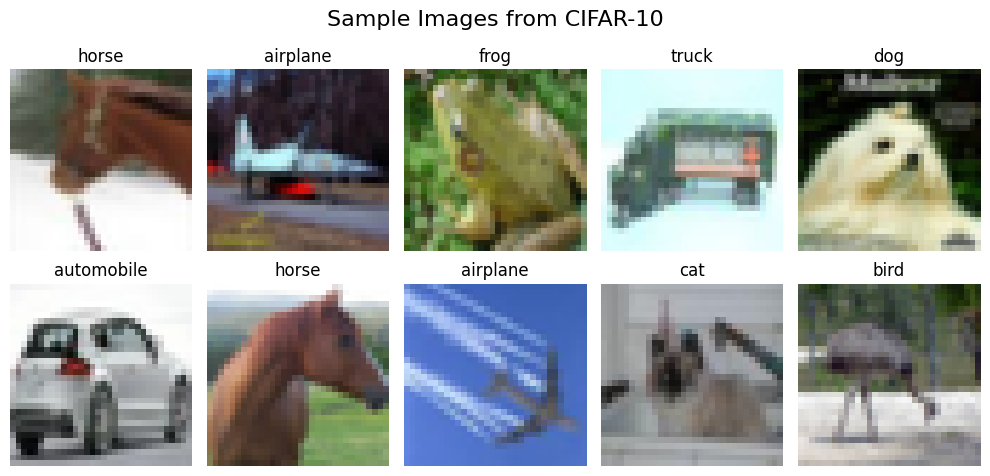

In [ ]:
import matplotlib.pyplot as plt

# Load raw CIFAR-10 again without preprocessing
raw_test = tfds.load('cifar10', split='test', as_supervised=True)

# CIFAR-10 label names
class_names = ds_info.features['label'].names

# Plot 10  images
plt.figure(figsize=(10, 5))
for i, (image, label) in enumerate(raw_test.take(10)):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(image.numpy())
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.suptitle("Sample Images from CIFAR-10", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Load MobileNetV2 pretrained
model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224, 224, 3), include_top=True)

# Since CIFAR-10 has 10 classes, we need to replace the top layer
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Fine-tune
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(ds_train.map(preprocess).batch(32), epochs=1)  # 1 epoch for demo


1258/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 102ms/step - accuracy: 0.7445 - loss: 0.7605

In [ ]:
# Accuracy for Native
loss, acc = model.evaluate(ds_test)
print(f"Native TF Accuracy: {acc:.4f}")

# Latency: Average over 100 predictions
sample_batch = next(iter(ds_test))[0][:1]

start = time.time()
for _ in range(100):
    _ = model.predict(sample_batch)
end = time.time()

native_latency = (end - start) / 100
print(f"Native TF Inference Time (per image): {native_latency:.4f} sec")


In [ ]:
# Convert to TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

tflite_size = os.path.getsize("model.tflite") / 1024  # KB
print(f"TFLite Model Size: {tflite_size:.2f} KB")


In [ ]:
# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Resize single image to match TFLite input
def run_tflite_inference(image):
    interpreter.set_tensor(input_details[0]['index'], image.numpy())
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    return output

# Accuracy
correct = 0
total = 0

for images, labels in ds_test.unbatch().batch(1).take(100):  # Evaluate on 100 samples
    img = tf.image.resize(images[0], (224, 224))
    img = tf.expand_dims(img, 0)
    pred = run_tflite_inference(img)
    if np.argmax(pred) == labels.numpy()[0]:
        correct += 1
    total += 1

tflite_acc = correct / total
print(f"TFLite Accuracy (100 samples): {tflite_acc:.4f}")

# Latency
start = time.time()
for _ in range(100):
    _ = run_tflite_inference(sample_batch)
end = time.time()

tflite_latency = (end - start) / 100
print(f"TFLite Inference Time (per image): {tflite_latency:.4f} sec")


In [ ]:
# Export model to ONNX
onnx_model_path = "model.onnx"
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=onnx_model_path)

# Model size
onnx_size = os.path.getsize(onnx_model_path) / 1024  # in KB
print(f"ONNX Model Size: {onnx_size:.2f} KB")


In [ ]:
import onnxruntime as ort
import numpy as np

# Load ONNX model
session = ort.InferenceSession(onnx_model_path, providers=['CPUExecutionProvider'])

# Get input and output names
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# Define ONNX inference function
def run_onnx_inference(image):
    image = tf.image.resize(image, (224, 224))  # just to be sure
    image = tf.expand_dims(image, 0).numpy().astype(np.float32) / 255.0
    pred = session.run([output_name], {input_name: image})[0]
    return pred


In [ ]:
# Evaluate on 100 test samples
correct = 0
total = 0

for images, labels in ds_test.unbatch().batch(1).take(100):
    pred = run_onnx_inference(images[0])
    if np.argmax(pred) == labels.numpy()[0]:
        correct += 1
    total += 1

onnx_acc = correct / total
print(f"ONNX Accuracy (100 samples): {onnx_acc:.4f}")


In [ ]:
# Re-define sample_batch correctly (a single image with shape [1, 224, 224, 3])
sample_image = next(iter(ds_test.unbatch().take(1)))[0]
sample_image = tf.image.resize(sample_image, (224, 224))
sample_image = tf.expand_dims(sample_image, axis=0).numpy().astype(np.float32) / 255.0

# Warmup
_ = session.run([output_name], {input_name: sample_image})

# Latency test
import time

start = time.time()
for _ in range(100):
    _ = session.run([output_name], {input_name: sample_image})
end = time.time()

onnx_latency = (end - start) / 100
print(f"ONNX Inference Time (per image): {onnx_latency:.4f} sec")


In [ ]:
import pandas as pd
summary = pd.DataFrame({
    "Engine": ["TensorFlow", "TFLite", "ONNX Runtime"],
    "Accuracy": [acc, tflite_acc, onnx_acc],
    "Latency (s)": [native_latency, tflite_latency, onnx_latency],
    "Model Size (KB)": [model.count_params() * 4 / 1024, tflite_size, onnx_size]  # Approx for TF
})

print(summary)


# 📘 Part 2: PyTorch-Based Inference Engine Comparison

This section mirrors the TensorFlow flow, but using **PyTorch** as the source framework. We'll train a CNN model on CIFAR-10 and export it into multiple inference formats supported by PyTorch.

## 🧠 Objectives
- Train the same CNN model in PyTorch
- Export the model to:
  - ✅ **TorchScript** (via `torch.jit.trace`)
  - ✅ **ONNX** (via `torch.onnx.export`)
- Evaluate and compare:
  - ✅ Accuracy on test set
  - ⚡ Inference latency
  - 📦 Model file size

## 🔄 Export Flow

PyTorch (nn.Module)
├──→ TorchScript (.pt) via torch.jit.trace
└──→ ONNX (.onnx) via torch.onnx.export


## 🚀 Inference Engines Compared

| Engine         | Description                                          |
|----------------|------------------------------------------------------|
| PyTorch Native | Direct inference using `model.eval()`               |
| TorchScript    | Optimized PyTorch graph with static compilation     |
| ONNX Runtime   | Runs PyTorch-exported ONNX models with high speed   |

## 📦 Tools
- PyTorch
- TorchScript (`torch.jit`)
- ONNX Export (`torch.onnx`)
- ONNX Runtime (Python)


In [ ]:
!pip install -q torch torchvision onnx onnxruntime

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)
classes = testset.classes


In [ ]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

# Train briefly (1 batch for speed)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.train()
for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    break  # quick demo


In [ ]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        total += 1
        if total == 100:
            break

torch_native_acc = correct / total
print(f"PyTorch Native Accuracy: {torch_native_acc:.4f}")


In [ ]:
import time
with torch.no_grad():
    _ = model(images)  # warm-up
    start = time.time()
    for _ in range(100):
        _ = model(images)
    end = time.time()

torch_native_latency = (end - start) / 100
print(f"PyTorch Native Latency: {torch_native_latency:.4f} sec")


In [ ]:
torch.save(model.state_dict(), "model_native.pth")
torch_native_size = os.path.getsize("model_native.pth") / 1024
print(f"PyTorch Native Model Size: {torch_native_size:.2f} KB")


In [ ]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
scripted_model = torch.jit.trace(model, dummy_input)
scripted_model.save("model_scripted.pt")

# Size
torchscript_size = os.path.getsize("model_scripted.pt") / 1024

# Accuracy
scripted_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = scripted_model(images)
        _, predicted = torch.max(output, 1)
        correct += (predicted == labels).sum().item()
        total += 1
        if total == 100:
            break

torchscript_acc = correct / total

# Latency
with torch.no_grad():
    _ = scripted_model(images)
    start = time.time()
    for _ in range(100):
        _ = scripted_model(images)
    end = time.time()
torchscript_latency = (end - start) / 100

print(f"TorchScript Accuracy: {torchscript_acc:.4f}")
print(f"TorchScript Latency: {torchscript_latency:.4f} sec")
print(f"TorchScript Model Size: {torchscript_size:.2f} KB")


In [ ]:
import onnx
import onnxruntime as ort

# Export to ONNX
torch.onnx.export(model,  , "model.onnx", input_names=["input"], output_names=["output"],
                  dynamic_axes={"input": {0: "batch"}, "output": {0: "batch"}}, opset_version=11)

onnx_size = os.path.getsize("model.onnx") / 1024
ort_session = ort.InferenceSession("model.onnx", providers=["CPUExecutionProvider"])

def run_onnx(image):
    image = image.cpu().numpy()
    return ort_session.run(["output"], {"input": image})[0]

# Accuracy
correct = 0
total = 0
for images, labels in testloader:
    images = torch.nn.functional.interpolate(images, (224, 224))
    result = run_onnx(images)
    predicted = result.argmax()
    correct += (predicted == labels.item())
    total += 1
    if total == 100:
        break
onnx_acc = correct / total

# Latency
_ = run_onnx(images)
start = time.time()
for _ in range(100):
    _ = run_onnx(images)
end = time.time()
onnx_latency = (end - start) / 100

print(f"ONNX Accuracy: {onnx_acc:.4f}")
print(f"ONNX Latency: {onnx_latency:.4f} sec")
print(f"ONNX Model Size: {onnx_size:.2f} KB")


In [ ]:
import pandas as pd

summary = pd.DataFrame([
    {"Engine": "PyTorch Native", "Accuracy": torch_native_acc, "Latency (s)": torch_native_latency, "Model Size (KB)": torch_native_size},
    {"Engine": "TorchScript", "Accuracy": torchscript_acc, "Latency (s)": torchscript_latency, "Model Size (KB)": torchscript_size},
    {"Engine": "ONNX Runtime", "Accuracy": onnx_acc, "Latency (s)": onnx_latency, "Model Size (KB)": onnx_size}
])

summary

# QUIZ

## Inference Engine Optimization Quiz (Hands-On)

### Objective:
Use a pretrained image classification model and convert it into **TorchScript** or **ONNX Runtime** (depending on your framework). Then evaluate and compare the **native model** and **converted model** in terms of:

---

### Main Tasks:

1. **Choose Your Model**
   - Select any model you choose, preferably your own model.

2. **Export the Model**
   - Convert the model to **TorchScript** or **TFLite** format
   - Convert the model to **ONNX Runtime** format.

3. **Prepare a Dataset**
   - Use a small test dataset with at least **100 images**.

4. **Perform Inference**
   - Run inference **twice**:
     -  **Native (original)** model
     -  **Optimized (converted)** model

5. **Compare the Following Metrics**
   -  **Accuracy**
   -  **Inference Latency** (average time per image)
   -  **Model File Size**

---

### Bonus Metrics (for extra points)

- Perform additional optimization that you have learned.
- **Throughput (TPS)**: Images processed per second  
  - Formula: `TPS = Total images / Total time`
-  **RAM Usage**: Track max memory during inference  
  - Use:
    ```python
    import psutil
    print(f"Memory used: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")
    ```

---

### Deliverables

For both native and converted models:
- [ ] Accuracy on 100 test images
- [ ] Inference time (total and per image)
- [ ] Model file size (in MB)
- [ ] Bonus: TPS and RAM usage

---

### Tips:
- Use `time.time()` before and after inference loop to calculate latency.
- Save model size with `os.path.getsize()`.



In [ ]:
# choose the model
import torch
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)
model.eval()
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 90.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# prepare dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

dataset = datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

dataset = Subset(dataset, range(100))
loader = DataLoader(dataset, batch_size=1, shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 31.2MB/s]


In [ ]:
# native model
model.eval()
correct, total = 0, 0

start = time.time()
with torch.no_grad():
  for x, y in loader:
    x, y = x.to(device), y.to(device)
    out = model(x)
    pred = out.argmax(dim=1)
    correct += (pred == y).sum().item()
    total +=1

latency = (time.time() - start) / total
accuracy = correct / total

In [ ]:
accuracy

0.0

In [ ]:
# convert ke TorchScript

dummy_input = torch.randn(1, 3, 224, 224).to(device)
traced_model = torch.jit.trace(model, dummy_input)
traced_model.save("resnet18_torchscript.pt")

# get model size
torchscript_size = os.path.getsize("resnet18_torchscript.pt") / 1024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')